In [1]:
# !python -m spacy download en_core_web_sm
# import spacy
# spacy.load('en_core_web_sm')

In [2]:
import spacy
import torch
import torchtext

from torchtext.legacy import datasets, data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Containers for tokenisation
# using tokenize="spacy" because it's the best.
text_field = data.Field(tokenize="spacy", tokenizer_language="en_core_web_sm")
label_field = data.LabelField(dtype=torch.float) # torch.float because GPUs use floats

# Load dataset and split to train and test data
# IMDB dataset (about movies)
train, test = datasets.IMDB.splits(text_field=text_field, label_field=label_field)

In [4]:
# Split to train and validation set - 80% to train_set, 20% to validation_set
# The original set is 25k descriptions(?) so train_set after the split is 20k and valid_set is 5k.
train_set, valid_set = train.split(0.8)
len(train_set), len(valid_set)  # 20_000, 5_000
text_field.build_vocab(train_set, max_size=25_000)
label_field.build_vocab(train_set)

assert len(text_field.vocab) == 25_002

In [5]:
# Map int to string and string to int
# text_field.vocab.itos[186] -> 'though'
# text_field.vocab.stoi['though'] -> 186

In [11]:
text_field.vocab.itos[:10]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

(array([1.22478386e-04, 1.27521614e-03, 1.62283862e-03, 2.01368876e-03,
        4.78206052e-03, 4.99459654e-03, 3.71757925e-03, 2.69632565e-03,
        2.00288184e-03, 1.78314121e-03, 1.43011527e-03, 1.20136888e-03,
        1.01585014e-03, 9.34798271e-04, 7.87103746e-04, 6.30403458e-04,
        5.51152738e-04, 5.24135447e-04, 4.50288184e-04, 3.72838617e-04,
        3.38616715e-04, 3.09798271e-04, 2.43155620e-04, 2.75576369e-04,
        2.07132565e-04, 1.90922190e-04, 1.76512968e-04, 1.27881844e-04,
        1.36887608e-04, 1.33285303e-04, 1.13472622e-04, 9.72622478e-05,
        7.56484150e-05, 8.64553314e-05, 8.10518732e-05, 4.14265130e-05,
        7.92507205e-05, 5.40345821e-05, 6.30403458e-05, 5.76368876e-05,
        5.22334294e-05, 5.94380403e-05, 4.50288184e-05, 1.62103746e-05,
        1.08069164e-05, 7.20461095e-06, 1.80115274e-06, 1.80115274e-06,
        3.60230548e-06, 1.80115274e-06, 1.80115274e-06, 3.60230548e-06,
        1.80115274e-06, 0.00000000e+00, 1.80115274e-06, 1.801152

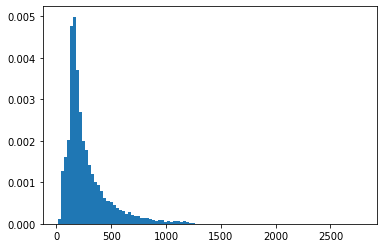

In [6]:
zz = [len(x.text) for x in train_set]

import matplotlib.pyplot as plt

plt.hist(zz, bins=100, density=1)

In [26]:
len(max(train_set, key=lambda x: len(x.text)).text)

# but we can do better!
train_buckets, valid_buckets, test_buckets = data.BucketIterator.splits(
    (train_set, valid_set, test), batch_size=64, device=device
)

In [78]:
from torch import nn


class NLPModule(nn.Module):
    def __init__(self, num_embedding, embedding_dim, hidden_size, out_features):
        # before parent
        super().__init__()
        # after parent
        # warstwa osadzeń/osadzanie(?) embedding
        # wektory w przestrzeni znaczeniowej słów
        self.embedding = nn.Embedding(num_embedding, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_size, 1)
        self.linear = nn.Linear(hidden_size, out_features)

    def forward(self, input):
        embed_output = self.embedding(input)
        rnn_output, hidden_output = self.rnn(embed_output)
        # hidden_output is the same as rnn_output[-1]
        lin_output = self.linear(hidden_output)

        return lin_output

In [76]:
>>> rnn = nn.RNN(3, 2, 1)
>>> input = torch.randn(5, 3, 3)
>>> h0 = torch.randn(1, 3, 2)
>>> output, hn = rnn(input, h0)
output, hn

(tensor([[[ 0.9660, -0.1706],
          [ 0.9672, -0.7801],
          [-0.2270,  0.8541]],
 
         [[ 0.7891, -0.1707],
          [ 0.8006, -0.1496],
          [ 0.5672,  0.5370]],
 
         [[-0.2784,  0.3488],
          [ 0.9865, -0.7433],
          [ 0.4907,  0.2776]],
 
         [[ 0.9574,  0.2454],
          [ 0.5468, -0.9582],
          [ 0.9314, -0.7436]],
 
         [[ 0.9846, -0.8240],
          [ 0.9579, -0.2523],
          [ 0.9662, -0.8882]]], grad_fn=<StackBackward>),
 tensor([[[ 0.9846, -0.8240],
          [ 0.9579, -0.2523],
          [ 0.9662, -0.8882]]], grad_fn=<StackBackward>))

In [48]:
>>> # an Embedding module containing 10 tensors of size 3
>>> embedding = nn.Embedding(100, 19)
>>> # a batch of 2 samples of 4 indices each
>>> input = torch.LongTensor([[1,99,1,0, 4,3,2,9],[4,3,2,9, 4,3,2,9]])
>>> embedding(input)

tensor([[[ 1.6748e+00,  1.3290e+00, -1.0851e+00,  1.7921e-01,  1.3326e+00,
           6.6932e-01, -3.6714e-01,  4.0046e-02, -1.7726e+00,  7.2906e-01,
          -1.0497e+00, -3.3009e-01, -3.3450e-02, -1.3239e+00,  1.2575e+00,
           6.7581e-01, -1.2782e+00,  4.1385e-01, -5.9990e-01],
         [-2.1702e-01, -6.4670e-01,  7.9576e-01,  1.0954e-01, -5.5521e-01,
           1.0289e+00, -1.5576e+00, -9.4372e-01, -2.4619e-01,  1.2873e+00,
           5.0346e-01,  1.8335e+00, -8.6647e-01,  4.6589e-02,  1.4953e-01,
           1.1952e+00, -1.0527e-01, -8.9555e-01, -2.4176e-01],
         [ 1.6748e+00,  1.3290e+00, -1.0851e+00,  1.7921e-01,  1.3326e+00,
           6.6932e-01, -3.6714e-01,  4.0046e-02, -1.7726e+00,  7.2906e-01,
          -1.0497e+00, -3.3009e-01, -3.3450e-02, -1.3239e+00,  1.2575e+00,
           6.7581e-01, -1.2782e+00,  4.1385e-01, -5.9990e-01],
         [ 1.1084e+00,  8.2885e-02,  3.6655e-01, -9.7490e-01, -8.0674e-01,
          -1.7280e-01,  1.2545e+00,  1.8969e-03, -1.4910e+00,